In [1]:
import cv2
import tifffile as tiff
import exifread 
import matplotlib.pyplot as pl
import numpy as np
import os
from __future__ import division

pts_origin = [  [279,30],
                [409,33],
                [130,750],
                [246,796],
                [649,110],
                [798,117],
                [498,832],
                [632,873],
                [1015,193],
                [1182,202],
                [860,913],
                [1013,959]]

pts_target = [  [175,66],
                [216,67],
                [125,298],
                [161,311],
                [292,92],
                [339,94],
                [241,324],
                [284,338],
                [408,118],
                [461,123],
                [358,351],
                [405,365]]

pts_origin = np.array(pts_origin).astype(float)
pts_target = np.array(pts_target).astype(float)

H = cv2.findHomography(pts_origin, pts_target)

298
13-20-14-165_digital.jpg 13-20-14-168_radiometric.tiff


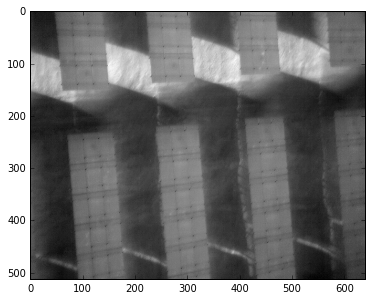

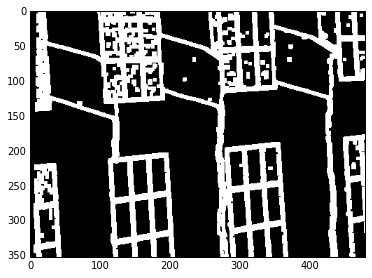

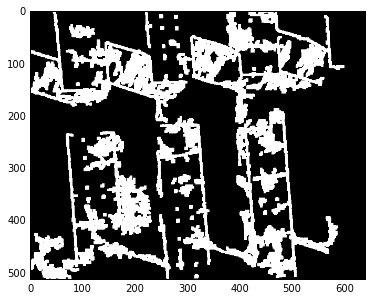

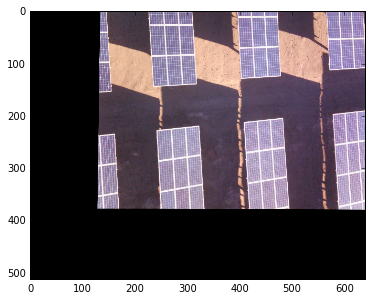

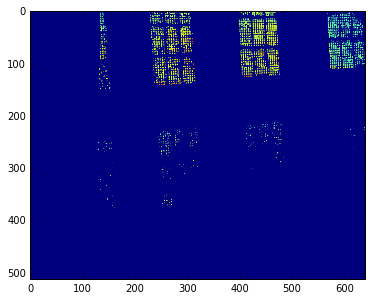

13-20-15-173_digital.jpg 13-20-15-174_radiometric.tiff


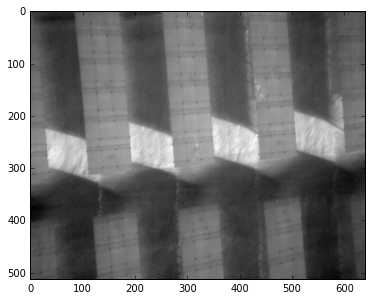

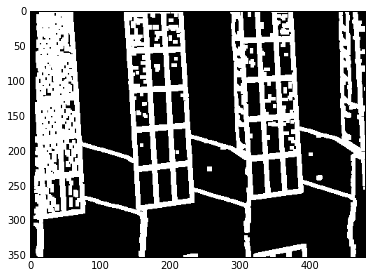

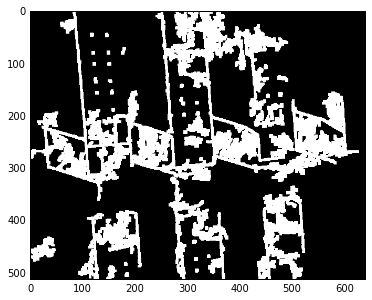

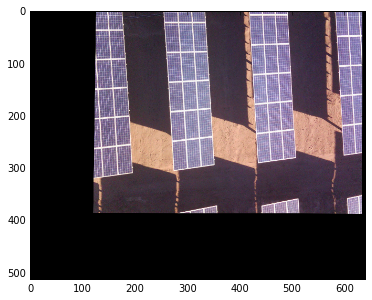

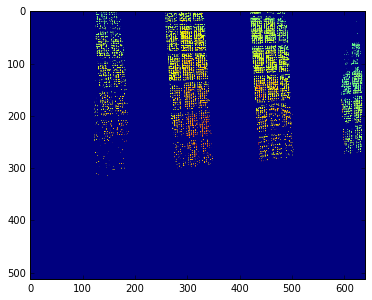

13-20-16-132_digital.jpg 13-20-16-137_radiometric.tiff


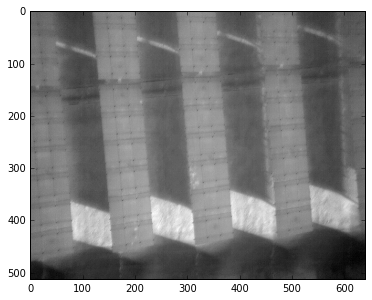

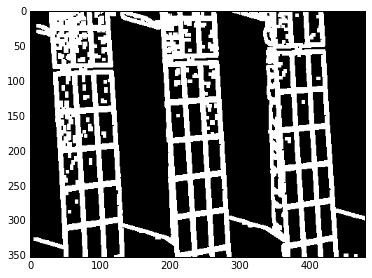

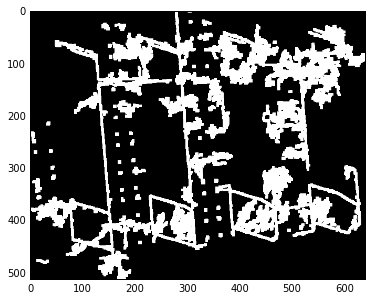

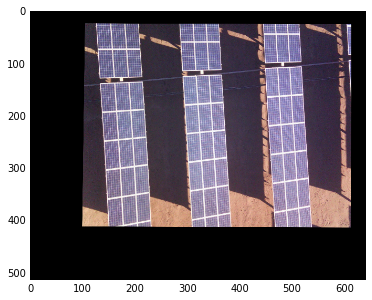

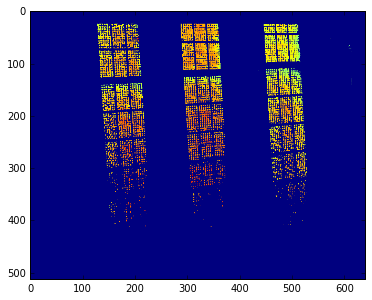

13-20-17-153_digital.jpg 13-20-17-154_radiometric.tiff


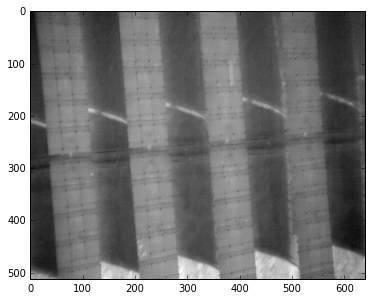

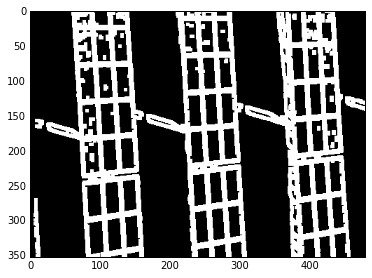

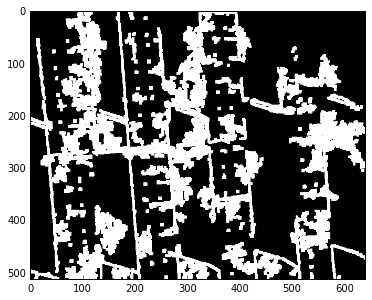

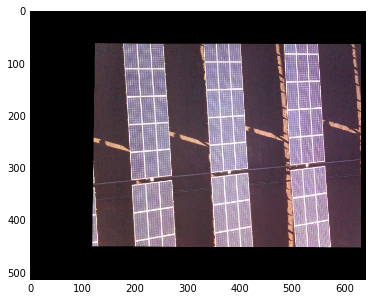

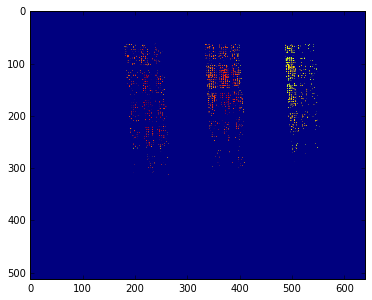

13-20-18-162_digital.jpg 13-20-18-166_radiometric.tiff


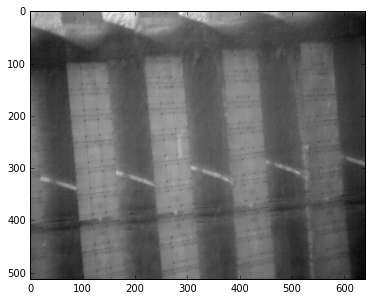

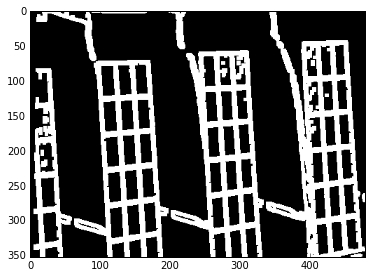

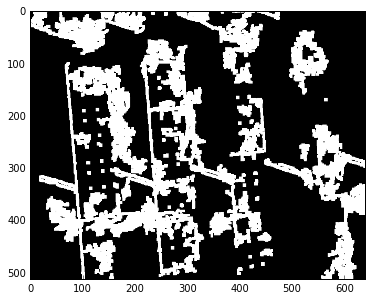

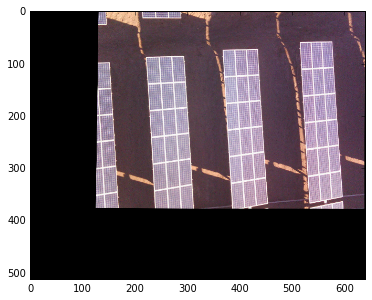

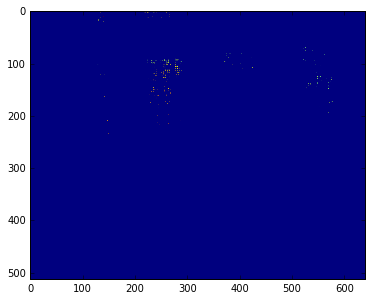

13-20-19-223_digital.jpg 13-20-19-225_radiometric.tiff


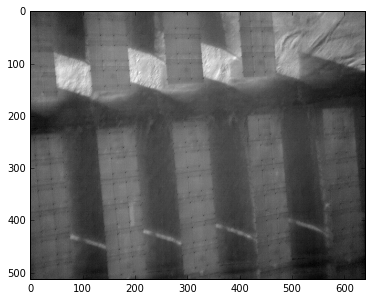

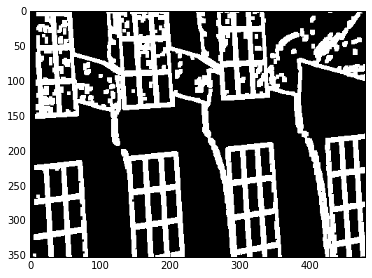

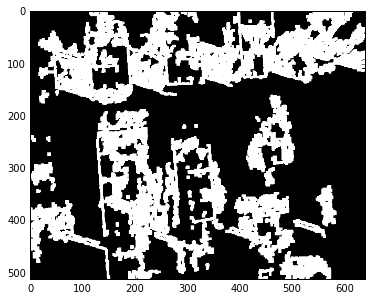

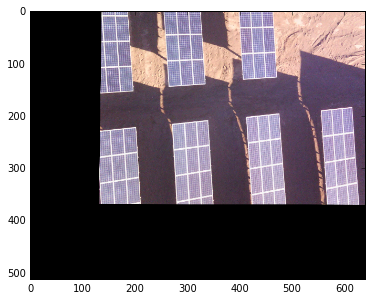

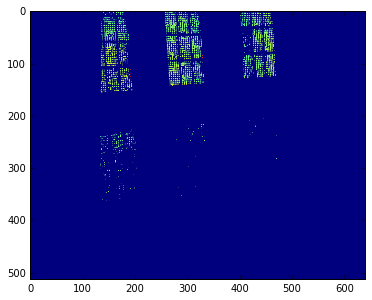

13-20-20-151_digital.jpg 13-20-20-153_radiometric.tiff


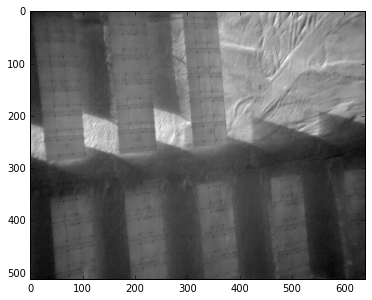

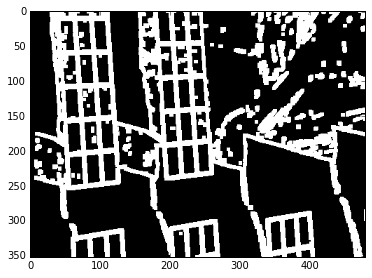

KeyboardInterrupt: 

In [5]:
# ejemplo para obtener homografía
img_dir = '/home/ivan/Documents/Adentu/DATA/Paneles/Vuelos/Vuelo_07_38m-7ms-SF72-SL60-GSD5/Imagenes'
# IRGB = cv2.cvtColor(cv2.imread(os.path.join(img_dir,'09-17-03-738_digital.jpg')), cv2.COLOR_BGR2RGB)
# ITERM = tiff.imread(os.path.join(img_dir, '09-17-03-752_radiometric.tiff')).astype(float)

RGBlist = sorted([o for o in os.listdir(img_dir) if 'digital.jpg' in o])
RAWlist = sorted([o for o in os.listdir(img_dir) if 'radiometric.tiff' in o])

print len(RGBlist)
base_height = None

for imrgb, imtiff in zip(RGBlist, RAWlist):
    if base_height is None:
        exif = exifread.process_file(open(os.path.join(img_dir,imrgb),'rb'))
        height = eval(str(exif['GPS GPSAltitude']))
        base_height = height
        
#     if '09-08-14-664_digital.jpg' not in imrgb:
#         continue    
    IRGB = cv2.cvtColor(cv2.imread(os.path.join(img_dir,imrgb)), cv2.COLOR_BGR2RGB)
    ITERM = tiff.imread(os.path.join(img_dir, imtiff)).astype(float)
    
    #print ITERM.min(), ITERM.max()

    exif = exifread.process_file(open(os.path.join(img_dir,imrgb),'rb'))
    
    height = eval(str(exif['GPS GPSAltitude']))
    
    if base_height is None:
        base_height = height
    
    #print height - base_height
    
    if height - base_height < 28:
        continue
    
    print imrgb, imtiff
    
    ITERM = ((ITERM - ITERM.min())/(ITERM.max()-ITERM.min())*255).astype(np.uint8)

    I2 = cv2.warpPerspective(IRGB, H[0], ITERM.shape[::-1], flags=cv2.INTER_AREA)
    
    pl.figure(figsize=(6,6))
    pl.imshow(ITERM, cmap='gray')
    tir
    pl.show()
    
    ERGB = cv2.Canny(I2, 250, 350)
    ERGB[np.where(cv2.dilate((I2[:,:,0]==0).astype(np.uint8)*255, np.ones((10,10))))] = 0
    ERGB = ERGB[80:-80, 80:-80]
    
    ERGB = cv2.dilate(ERGB, np.ones((5,5)))
    #ERGB = cv2.GaussianBlur(ERGB, (11,11),2)
    
    pl.figure(figsize=(6,6))
    pl.imshow(ERGB, cmap='gray')
    pl.show()

    ETERM = cv2.Canny(ITERM, 10, 140)
    ETERM = cv2.dilate(ETERM, np.ones((5,5)))
    #ETERM = cv2.GaussianBlur(ETERM, (11,11),2)
    #ETERM[np.where(cv2.dilate((I2[:,:,0]==0).astype(np.uint8)*255, np.ones((10,10))))] = 0

    pl.figure(figsize=(6,6))
    pl.imshow(ETERM, cmap='gray')
    pl.show()

    res = cv2.matchTemplate(ERGB, ETERM, cv2.TM_CCOEFF_NORMED)

#     pl.figure(figsize=(12,12))
#     pl.imshow(res)
#     pl.show()

    a = res.argmax()

    xd = a%res.shape[0] - 80
    yd = a//res.shape[0] - 80

    #print xd, yd

    H2 = np.array([[1,0,xd],[0,1,yd],[0,0,1]]).astype(np.float)
    I3 = cv2.warpPerspective(I2, H2, (I2.shape[1], I2.shape[0]), flags=cv2.INTER_AREA)

    pl.figure(figsize=(6,6))
    pl.imshow(I3)
    pl.show()
    
    I2LAB = cv2.cvtColor(I3, cv2.COLOR_RGB2LAB)
    #I2LAB = I3
    
#     pl.figure(figsize=(12,6))
#     pl.imshow(np.concatenate((I3[:,:,0],I3[:,:,1],I3[:,:,2]), axis=1), cmap='gray')
#     pl.show()

#   IMASK = (I2LAB[:,:,2]<110) * (I2LAB[:,:,0]>60) * (I2LAB[:,:,0]<160) * (ITERM > 100)
    IMASK = (I2LAB[:,:,2]<110) * (I2LAB[:,:,0]>40) * (I2LAB[:,:,0]<160) * (ITERM > 100) * (I3[:,:,2] > I3[:,:,0]+30)

    #IMASK2 = cv2.erode(cv2.dilate(IMASK.astype(np.uint8), np.ones((10,10))), np.ones((10,10)))
    pl.figure(figsize=(6,6))
    pl.imshow(IMASK*ITERM)
    pl.show()


In [27]:
cv2.GaussianBlur?